In [1]:
import logging
import warnings
import datetime
import sys
import pickle
import gc
from glob import glob
import time
from itertools import product

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from shapely.geometry import box
from statsmodels import api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pylab

# warnings.filterwarnings("ignore")
logging.basicConfig(format='%(asctime)s [%(levelname).7s] %(message)s',
                    datefmt='%d/%m %H:%M:%S', level=logging.INFO)
logger = logging.getLogger()

pd.set_option('display.max_columns', 3000)


In /Users/s.komissarov/anaconda3/envs/dc_main/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/s.komissarov/anaconda3/envs/dc_main/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/s.komissarov/anaconda3/envs/dc_main/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/s.komissarov/anaconda3/envs/dc_main/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two mi

### 1) Составьте из данных о поездках прямоугольную таблицу
так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [2]:
regions = pd.read_csv('../data/regions.csv', sep=';', index_col=0)

region_mapping = {}
for i, row in regions.iterrows():
    region_mapping[(row['west'], row['south'])] = i
    
bins_lon = sorted(list(set(regions['west'].unique().tolist() + regions['east'].unique().tolist())))
bins_lat = sorted(list(set(regions['south'].unique().tolist() + regions['north'].unique().tolist())))

# с 2015 года появлется ещё 1 столбец
cols_18 = ['vendor', 'pickup_time', 'dropoff_time', 'passenger_count', 'trip_distance',
           'start_lon', 'start_lat', 'rate', 'store_and_forward', 'end_lon', 'end_lat',
           'payment_type', 'fare_amount', 'surcharge', 'tax', 'tip_amount', 'tolls_amount', 'total_amount']

cols_19 = ['vendor', 'pickup_time', 'dropoff_time', 'passenger_count', 'trip_distance',
           'start_lon', 'start_lat', 'rate', 'store_and_forward', 'end_lon', 'end_lat',
           'payment_type', 'fare_amount', 'surcharge', 'tax', 'tip_amount', 'tolls_amount', 
           'improvement_surcharge', 'total_amount']

def read_data(file_path, nrows=None):
    file = file_path.replace(' ', '\ ').split('/')[-1]
    y = int(file[file.find('20'):file.find('20') + 4])
    if y < 2015:
        columns = cols_18
    else:
        columns = cols_19
    logging.info('Reading {}'.format(file))
    data = pd.read_csv(file_path, names=columns, skiprows=1, nrows=nrows,
                       parse_dates=['pickup_time', 'dropoff_time'], dayfirst=True)
    logging.info('{} shape = {}'.format(file, data.shape))
    return data

def map_region(data):
    data['start_lon_bin'] = pd.cut(data['start_lon'], bins=bins_lon,
                                   precision=25, include_lowest=True)
    data['start_lat_bin'] = pd.cut(data['start_lat'], bins=bins_lat,
                                   precision=25, include_lowest=True)
    region_id = []
    for lon, lat in zip(data['start_lon_bin'], data['start_lat_bin']):
        region_id.append(region_mapping[(lon.left, lat.left)])
    data['region_id'] = region_id  
    return data

def clear_data(data):
    res = data[(data['trip_distance'] > 0) &
               (data['passenger_count'] > 0) &
               (data['dropoff_time'] > data['pickup_time']) &
               (data['start_lon'] >= -74.25559) &
               (data['start_lon'] <= -73.70001) &
               (data['start_lat'] >= 40.49612) &
               (data['start_lat'] <= 40.91553)]
    return res

def aggregate_data(data, region_id=None):
    data['hour'] = data['pickup_time'].dt.hour
    data['date'] = data['pickup_time'].dt.date
    data_agg = data.groupby(['region_id', 'date', 'hour']).size().rename('count')
    min_date = data['date'].min()
    max_date = data['date'].max()
    
    data_range = pd.DataFrame(pd.date_range(min_date, max_date + datetime.timedelta(days=1), freq='1H')[:-1],
                              columns=['datetime'])
    regions_df = pd.DataFrame(list(range(1, 2501)), columns=['region_id'])
    if region_id:
        regions_df = regions_df[regions_df['region_id'] == region_id]
    data_range['tmp'] = 1
    regions_df['tmp'] = 1

    timeseries = pd.merge(data_range, regions_df, how='outer').drop('tmp', axis=1)
    timeseries['date'] = timeseries['datetime'].dt.date
    timeseries['hour'] = timeseries['datetime'].dt.hour
    timeseries = timeseries.set_index(['region_id', 'date', 'hour'])
    
    data_full = timeseries.join(data_agg) \
                          .fillna(0) \
                          .sort_values(by='count', ascending=False) \
                          .reset_index()
    
    return data_full

def read_and_process(file_path, nrows=None):
    logging.info('Processing {}'.format(file_path))
    data = read_data(file_path, nrows=nrows)
    logging.info('Clearing {}'.format(file_path))
    data = clear_data(data)
    logging.info('Mapping regions {}'.format(file_path))
    data = map_region(data)
    logging.info('Aggregating {}'.format(file_path))
    data = aggregate_data(data)
    logging.info('Finished {}'.format(file_path))
    return data

def get_one_region(file_path, region_id):
    logging.info('Processing {}'.format(file_path))
    data = read_data(file_path, nrows=nrows)

    region_info = regions[regions.index == region_id].iloc[0].values
    data = data[(data['start_lon'] >= region_info[0]) &
                (data['start_lon'] < region_info[1]) &
                (data['start_lat'] >= region_info[2]) &
                (data['start_lat'] < region_info[3])]
    logging.info('Clearing {}'.format(file_path))
    data = clear_data(data)
    data['region_id'] = region_id
    logging.info('Aggregating {}'.format(file_path))
    data = aggregate_data(data, region_id=region_id)
    logging.info('Finished {}'.format(file_path))
    return data

In [3]:
regions = open('../data/regions.txt', 'r').read()
regions = list(map(int, regions.split(',')))
len(regions)

102

In [4]:
all_dates = []
for file in tqdm(sorted(glob('../data_pickle/yellow_tripdata*.pickle'))):
    data = pickle.load(open(file, 'rb'))
    all_dates.append(data[data['region_id'].isin(regions)])

In [5]:
df = pd.concat(all_dates)
del data, all_dates
df = df[df['date'] < pd.to_datetime('2016-05-01')]
df = df[df['date'] >= pd.to_datetime('2016-01-01')]
gc.collect()

0

In [6]:
df_pivot = df.pivot_table('count', 'datetime', 'region_id')
del df
df_pivot.T

datetime   2016-01-01 00:00:00  2016-01-01 01:00:00  2016-01-01 02:00:00  \
region_id                                                                  
1075                      80.0                 91.0                 90.0   
1076                     144.0                211.0                146.0   
1077                      50.0                 49.0                 23.0   
1125                      77.0                134.0                110.0   
1126                     319.0                404.0                393.0   
...                        ...                  ...                  ...   
2068                      41.0                  4.0                  0.0   
2069                       4.0                  0.0                  0.0   
2118                      70.0                 47.0                 69.0   
2119                       7.0                  1.0                  1.0   
2168                      66.0                 29.0                 14.0   

datetime   2016-01-01 03:00:00  2016-01-01 04:00:00  2016-01-01 05:00:00  \
region_id                                                                  
1075                      32.0                 24.0                 11.0   
1076                      87.0                 43.0                 18.0   
1077                      16.0                 10.0                  5.0   
1125                      62.0                 53.0                 17.0   
1126                     252.0                145.0                 52.0   
...                        ...                  ...                  ...   
2068                       1.0                  0.0                 34.0   
2069                       0.0                  0.0                  3.0   
2118                      21.0                 26.0                 73.0   
2119                       0.0                  1.0                  1.0   
2168                       9.0                  6.0                 80.0   

datetime   2016-01-01 06:00:00  2016-01-01 07:00:00  2016-01-01 08:00:00  \
region_id                                                                  
1075                       7.0                  9.0                 18.0   
1076                      25.0                 25.0                 26.0   
1077                       3.0                 10.0                  9.0   
1125                      17.0                 15.0                 20.0   
1126                      39.0                 42.0                 70.0   
...                        ...                  ...                  ...   
2068                      34.0                 62.0                 48.0   
2069                       5.0                 11.0                 10.0   
2118                      90.0                 73.0                 53.0   
2119                       8.0                 11.0                  7.0   
2168                      82.0                 66.0                 92.0   

datetime   2016-01-01 09:00:00  2016-01-01 10:00:00  2016-01-01 11:00:00  \
region_id                                                                  
1075                      22.0                 27.0                 54.0   
1076                      38.0                 82.0                154.0   
1077                      17.0                 34.0                 64.0   
1125                      29.0                 42.0                 61.0   
1126                      67.0                 97.0                170.0   
...                        ...                  ...                  ...   
2068                      30.0                 66.0                 37.0   
2069                       0.0                  2.0                  3.0   
2118                      55.0                 75.0                 54.0   
2119                      17.0                 16.0                  8.0   
2168                      88.0                 61.0                 43.0   

datetime   2016-01-01 12:00:00  2016-01-01 1

### 2) Перед проведением кластеризации стандартизуйте столбцы
(вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.

In [7]:
scaler = StandardScaler()
df_pivot_scaled = pd.DataFrame(
    scaler.fit_transform(df_pivot),
    index=df_pivot.index,
    columns=df_pivot.columns,
).T

### 3) Кластеризуйте географические зоны по значениям стандартизованных рядов.
Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

/Users/s.komissarov/anaconda3/envs/dc_main/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='n_clusters', ylabel='inertia'>

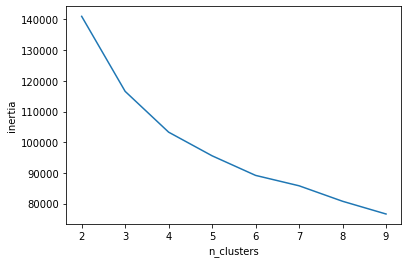

In [8]:
score = []
for i in tqdm(range(2, 10)):
    kmeans = KMeans(n_clusters=i, random_state=42)
    clusters = kmeans.fit_predict(df_pivot_scaled)
    score.append(kmeans.inertia_)
df_score = pd.DataFrame({'n_clusters': list(range(2, 10)), 'inertia': score})
sns.lineplot(df_score['n_clusters'], df_score['inertia'])

In [9]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(df_pivot_scaled)
kmeans.labels_

array([0, 1, 1, 0, 0, 0, 0, 3, 3, 0, 1, 2, 2, 2, 2, 3, 3, 3, 0, 0, 1, 2,
       1, 1, 3, 3, 3, 2, 2, 3, 3, 0, 0, 0, 0, 0, 1, 1, 3, 3, 3, 2, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 0, 0, 3, 3, 3, 3,
       0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

### 4) В каждом кластере выберите наиболее типичный ряд
(например, это может быть ряд, соответствующий центру кластера).

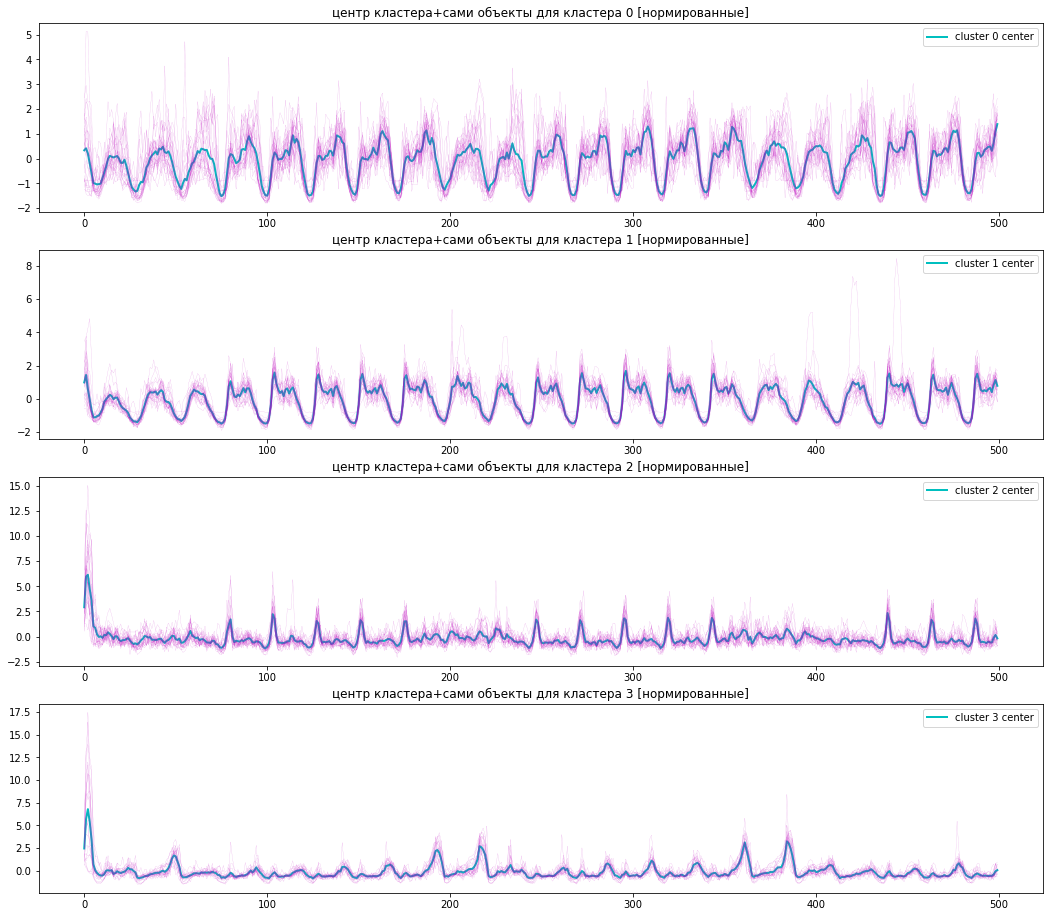

In [15]:
colors = ['c', 'm', 'b', 'y','c','m','r', 'g']
max_points = 500
fig, axes = plt.subplots(nrows=n_clusters, figsize=(18,16))

for curr_cluster in range(n_clusters):
    curr_ax = axes[curr_cluster]
    curr_ax.set_title("центр кластера+сами объекты для кластера %i [нормированные]" % curr_cluster)
    curr_ax.plot(
        np.transpose(kmeans.cluster_centers_[curr_cluster, :max_points]),
        color=colors[0],
        linestyle='-',
        lw=2,
        label='cluster %i center' % curr_cluster
    )
    curr_ax.plot(
        np.transpose(df_pivot_scaled.values[kmeans.labels_== curr_cluster][:, :max_points]),
        color=colors[1],
        linestyle='dotted',
        lw=0.2
    )
    curr_ax.legend(loc='best');

plt.show()

In [16]:
labels = kmeans.transform(df_pivot_scaled)
min_idx = np.argmin(labels, axis=0)
best_series = df_pivot.T.iloc[min_idx].values
best_series_idx = df_pivot.T.iloc[min_idx].index

/Users/s.komissarov/anaconda3/envs/dc_main/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/s.komissarov/anaconda3/envs/dc_main/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/s.komissarov/anaconda3/envs/dc_main/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword wil

[]

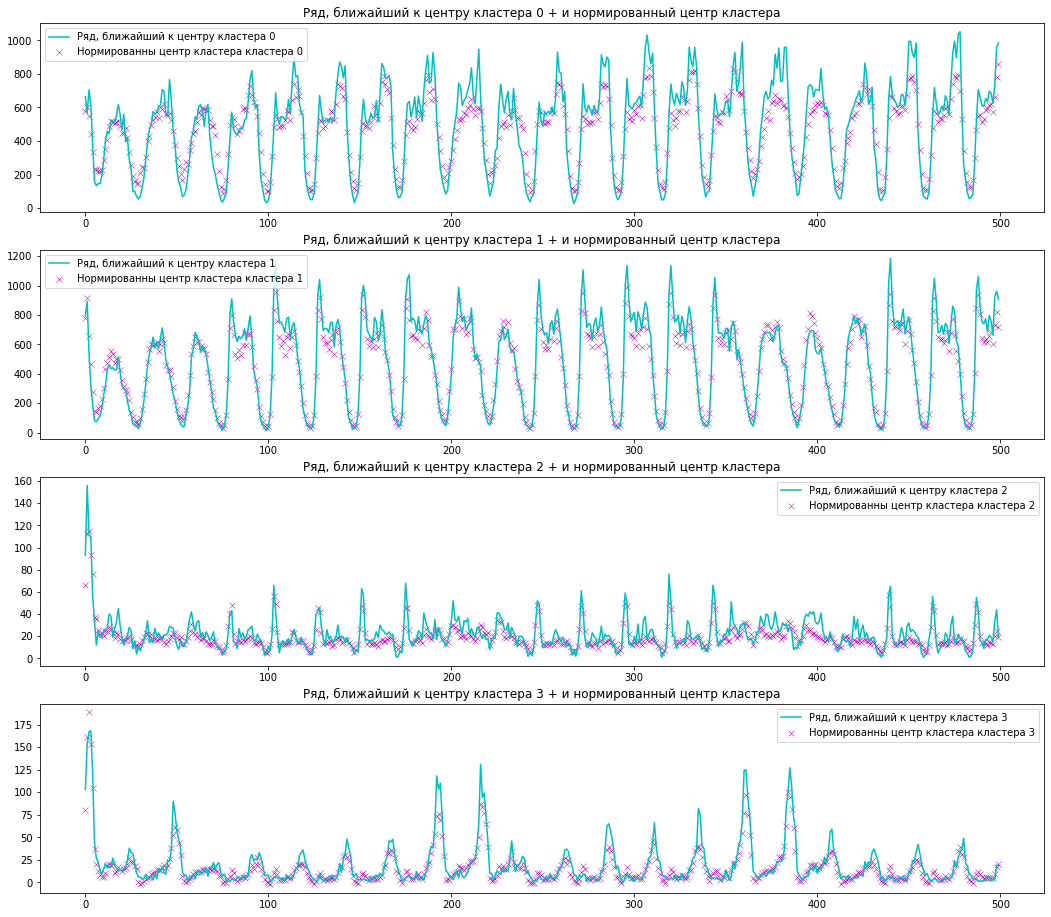

In [17]:
fig, ax = plt.subplots(nrows=n_clusters, figsize=(18, 16))

for i in range(n_clusters):
    current_ax = ax[i]
    current_ax.set_title(f'Ряд, ближайший к центру кластера {i} + и нормированный центр кластера')
    
    scaler.fit(best_series[i, :max_points].reshape(-1, 1))
    series_rev = scaler.inverse_transform(kmeans.cluster_centers_[i])
    
    sns.lineplot(
        range(max_points),
        best_series[i, :max_points],
        color=colors[0],
        linestyle='-',
        ax=current_ax,
        label=f'Ряд, ближайший к центру кластера {i}'
    )
    sns.scatterplot(
        range(max_points), 
        series_rev[:max_points],
        color=colors[1],
        marker='x',
        ax=current_ax,
        label=f'Нормированны центр кластера кластера {i}'
    )
    
plt.plot()

### 5) Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей
— набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Qp,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!

In [ ]:
cal = calendar() # производственный календарь США
holidays = cal.holidays(start=df_pivot.columns.min(), end=df_pivot.columns.max()).date

def create_features(data):
    k = 15
    t = np.arange(1, data.shape[0] + 1)
    for i in range(7):
        data['weekday_' + str(i)] = data['datetime'].dt.date.apply(lambda x: int(x.weekday() == i))

    data['weekday'] = data['datetime'].dt.weekday
    data['day_of_month'] = data['datetime'].dt.day
    data['hour_of_day'] = data['datetime'].dt.hour
    data['is_weekend'] = data['datetime'].dt.weekday.isin([5, 6]).astype(int)
    data['is_holiday'] = data['datetime'].dt.date.isin(holidays).astype(int)


    # недельная сезонность
    lag = 168
    for i in range(1, k + 1):
        s = np.sin(t * 2 * np.pi * i / lag)
        c = np.cos(t * 2 * np.pi * i / lag)
        s_name = 'sin_{}_{}'.format(i, lag)
        c_name = 'cos_{}_{}'.format(i, lag)
        data[s_name] = s
        data[c_name] = c
    
    data['const'] = 1
    return data

In [ ]:
def plot(cluster):
    data = create_features(cluster)
    X = data.drop(['count', 'datetime'], axis=1)
    y = data['count']
    m = sm.OLS(y, X).fit()
    plt.figure(figsize=(25,10))
    data['reg_pred'] = m.predict(data.drop(['count', 'datetime'], axis=1))
    data['count'].iloc[-488:].plot()
    data['reg_pred'].iloc[-488:].plot()
    plt.title('Regression model',size=24)
    plt.legend(fontsize=24)
    plt.show()

    plt.figure(figsize=(25,10))
    data['reg_resid'] = m.resid
    data['reg_resid'].iloc[-488:].plot()
    plt.title('Regression resids',size=24)
    plt.show()
    print("Mean error: ", m.resid.mean())
    print("MSE: ", (data['reg_resid'] ** 2).mean())
    print("MAE: ", data['reg_resid'].abs().mean())

    pylab.rcParams['figure.figsize'] = (40, 16)
    data['diff_24'] = data['count'].diff(24)
    sm.tsa.seasonal_decompose(data.iloc[-488:].set_index('datetime')[['diff_24']], period=24).plot()
    print('####################### Diff 24 #######################')
    plt.show()

    pylab.rcParams['figure.figsize'] = (40, 16)
    data['diff_1'] = data['count'].diff(1)
    sm.tsa.seasonal_decompose(data.iloc[-488:].set_index('datetime')[['diff_1']], period=24).plot()
    print('####################### Diff 1 #######################')
    plt.show()

    pylab.rcParams['figure.figsize'] = (40, 16)
    data['diff_25'] = data['count'].diff(25)
    sm.tsa.seasonal_decompose(data.iloc[-488:].set_index('datetime')[['diff_25']], period=24).plot()
    print('####################### Diff 25 #######################')
    plt.show()

    for (target_col_name, start_idx) in [('diff_25', 24 + 1)]:    
        plt.figure(figsize=(15,8))
        ax = plt.subplot(211)
        take_each_n_point = 5
        idx_to_take = [i for i in range(start_idx, cluster[target_col_name].shape[0], take_each_n_point)]

        sm.graphics.tsa.plot_acf(cluster[target_col_name].iloc[idx_to_take].values.squeeze(), lags=168, ax=ax, title='Autocorr - ' + target_col_name)
        pylab.show()

        plt.figure(figsize=(15,8))
        ax = plt.subplot(212)
        sm.graphics.tsa.plot_pacf(cluster[target_col_name].iloc[idx_to_take].values.squeeze(), lags=168, ax=ax, title='Part Autocorr - ' + target_col_name)

        pylab.show()
    return data
    

In [ ]:
def arima_fit(data, D, d, Q, q, P, p):
    Qs = range(Q, Q + 1)
    qs = range(q, q + 1)
    Ps = range(P, P + 1)
    ps = range(p, p + 1)

    all_params = list(product(ps, qs, Ps, Qs))
    logger.info(f'len(all_params)={len(all_params)}')
    data = data.iloc[-4392:]

    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    for param in tqdm(all_params):
        logger.info(param)
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(data['diff_25'], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], 24),
                                            initialization='approximate_diffuse').fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            logger.info(f'wrong parameters: param')
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    warnings.filterwarnings('default')
    return results, best_model

In [ ]:
all_clusters = []
for n in range(n_clusters):
    df = pd.DataFrame(
        {'datetime': df_pivot_scaled.columns, 'count': kmeans.cluster_centers_[n]}
    )
    all_clusters.append(df)
pickle.dump(all_clusters, open('cluster_data_for_arima.pkl', 'wb'))

In [ ]:
all_clusters = pickle.load(open('cluster_data_for_arima.pkl', 'rb'))
all_features = []
for i, cluster in enumerate(all_clusters):
    logger.info(f'CURRENT CLUSTER #{i}')
    features_cluster = plot(cluster)
    all_features.append(features_cluster)
pickle.dump(all_features, open('cluster_features.pkl', 'wb'))

In [20]:
all_res_fit = []
all_features = pickle.load(open('cluster_features.pkl', 'rb'))

In [101]:
logger.info(f'CURRENT CLUSTER #0')
res_fit = arima_fit(all_features[0], 0, 0, 5, 11, 6, 11)
all_res_fit.append(res_fit)

logger.info(f'CURRENT CLUSTER #1')
res_fit = arima_fit(all_features[1], 0, 0, 5, 10, 6, 11)
all_res_fit.append(res_fit)

logger.info(f'CURRENT CLUSTER #2')
res_fit = arima_fit(all_features[2], 0, 0, 4, 10, 5, 10)
all_res_fit.append(res_fit)

logger.info(f'CURRENT CLUSTER #3')
res_fit = arima_fit(all_features[3], 0, 0, 4, 10, 3, 10)
all_res_fit.append(res_fit)

04/10 23:08:46 [INFO] CURRENT CLUSTER #0
04/10 23:08:46 [INFO] len(all_params)=1


04/10 23:08:46 [INFO] (11, 11, 6, 5)
04/10 23:41:57 [INFO] CURRENT CLUSTER #1
04/10 23:41:57 [INFO] len(all_params)=1


04/10 23:41:57 [INFO] (11, 10, 6, 5)
05/10 00:16:28 [INFO] CURRENT CLUSTER #2
05/10 00:16:28 [INFO] len(all_params)=1


05/10 00:16:29 [INFO] (10, 10, 5, 4)
05/10 00:27:52 [INFO] CURRENT CLUSTER #3
05/10 00:27:52 [INFO] len(all_params)=1


05/10 00:27:52 [INFO] (10, 10, 3, 4)


In [102]:
pickle.dump(all_res_fit, open('all_res_fit.pkl', 'wb'))

/Users/s.komissarov/anaconda3/envs/dc_main/lib/python3.6/site-packages/ipykernel_launcher.py:1: ResourceWarning: unclosed file <_io.BufferedWriter name='all_res_fit.pkl'>
  """Entry point for launching an IPython kernel.


In [21]:
all_res_fit = pickle.load(open('all_res_fit.pkl', 'rb'))

In [22]:
res_fit = arima_fit(all_features[0], 0, 0, 5, 11, 6, 11)
all_res_fit[0] = res_fit

05/10 17:19:31 [INFO] len(all_params)=1


05/10 17:19:31 [INFO] (11, 11, 6, 5)


KeyboardInterrupt: 